In [2]:
state_reordered = [2,6,1,7,3,5,0,4]

brain_states_dict = {
    1: "Higher-order Anterior",
    2: "Higher-order Posterior",
    3: "Unimodal Visual",
    4: "Unimodal Sensorimotor",
    5: "Lateralized Language versus SMN",
    6: "Lateralized Visual versus DMN",
    7: "Suppressed Visual-(DMN-FPN) Ventral",
    8: "Suppressed General"
    }

In [3]:
n_states = 8

import os
import numpy as np
import matplotlib.pyplot as plt
from osl_dynamics.analysis import power, connectivity
from osl_dynamics.utils import plotting

# Directories
BASE_DIR = "E:/Research_Projects/MEG_CamCAN"
# BASE_DIR = "/media/clement/Transcend_Clement2/Research_Projects/MEG_CamCAN"
spectra_dir = f"{BASE_DIR}/TDE_HMM/results/inf_params/{n_states:02d}_states"
output_dir = f"{BASE_DIR}/TDE_HMM/output"

os.makedirs(output_dir, exist_ok=True)

# Source reconstruction files
mask_file = "MNI152_T1_8mm_brain.nii.gz"
parcellation_file = "Glasser52_binary_space-MNI152NLin6_res-8x8x8.nii.gz"

f = np.load(f"{spectra_dir}/f.npy")  # (n_freq,)
psd = np.load(f"{spectra_dir}/psd.npy")[:,state_reordered,...]  # (n_subjects, n_states, n_parcels, n_freq)
coh = np.load(f"{spectra_dir}/coh.npy")[:,state_reordered,...]  # (n_subjects, n_states, n_parcels, n_parcels, n_freq)
w = np.load(f"{spectra_dir}/w.npy")  # (n_subjects,)

# Import fractional occupancies to be used as weights
fo = np.load(f"{BASE_DIR}/TDE_HMM/results/inf_params/{n_states:02d}_states/fo.npy")[:,state_reordered]
gfo = np.mean(fo, axis=0)
np.save(f"{BASE_DIR}/TDE_HMM/results/inf_params/{n_states:02d}_states/gfo_ordered.npy", gfo)

print(f.shape)
print(psd.shape)
print(coh.shape)
print(w.shape)
print(gfo.shape)

(88,)
(621, 8, 52, 88)
(621, 8, 52, 52, 88)
(621,)
(8,)


Find state-relevant frequency ranges with NNMF

In [ ]:
# from osl_dynamics.analysis import spectral

###############
# NNMF -
# for state in range(8):
#     nnmf = spectral.decompose_spectra(coh[:,state,...], n_components=4)
#     np.save(f"{output_dir}/2_Brain_state_analysis/nnmf/nnmf_{state+1}.npy", nnmf)
###############

################
# LOAD NNMF components
nnmf_state_list = []
for state in range(8): 
    nnmf_tmp = np.load(f"{output_dir}/2_Brain_state_analysis/nnmf/nnmf_{state+1}.npy")  
    nnmf_state_list.append(nnmf_tmp)
nnmf_state = np.stack(nnmf_state_list) # (n_states, n_components, n_freq)

# for state in range(8): 
# # Visualize and match to the state-relevant PSD
#     plotting.plot_line(
#         [f,f,f,f],  # we need to repeat f times because we fitted f components
#         nnmf_state[state,...],
#         x_label="Frequency (Hz)",
#         y_label="Spectral Component",
#         labels=[f"Mode {mode+1}" for mode in range(4)],
#         title=f"State {state+1}"
#     )  # (n_components, n_freq)
################

################
# Final chosen components
weights_freqranges = np.stack(
    (nnmf_state[0,0,:],
    nnmf_state[1,1,:],
    nnmf_state[2,0,:],
    nnmf_state[3,1,:],
    nnmf_state[4,0,:],
    nnmf_state[5,1,:],
    nnmf_state[6,1,:],
    nnmf_state[7,1,:])
)

np.save(f"{spectra_dir}/2_Brain_state_analysis/weights_freqranges.npy", weights_freqranges) # For averaging over frequencies

fig, ax = plotting.plot_line(
        [f]*8,
        weights_freqranges-np.average(weights_freqranges,axis=0,weights=gfo)[np.newaxis,:],
        x_label="Frequency (Hz)",
        y_label="Spectral Component",
        labels = [f"{brain_states_dict[i+1]} (State {i+1})" for i in range(8)],
        title="State-relevant frequency ranges"
    ) # (n_components, n_freq)
plt.legend(fontsize=8)
plt.tight_layout()
fig.savefig(f"{output_dir}/2_Brain_state_analysis/figs/state_relevant_freqranges.png")

Power spectra

In [ ]:
# Calculate the group average power spectrum for each state
gpsd = np.average(psd, axis=0, weights=w) # average across subjects
gpsd_static = np.average(gpsd, axis=0, weights=gfo) # average across states
gpsd_dyn = gpsd - gpsd_static[np.newaxis,...]

from osl_dynamics.utils.parcellation import Parcellation

# Re-order to use colour to indicate anterior->posterior location
parcellation = Parcellation(parcellation_file)
roi_centers = parcellation.roi_centers()
order = np.argsort(roi_centers[:, 1]) # Anterior-to-Posterior reordering of the parcels

gpsd_dyn_reordered = gpsd_dyn[:,order,:]

In [ ]:
gpsd_mean_channels = np.mean(gpsd, axis=-2) # Mean across channels
gpsd_mean_channels_err = np.std(gpsd, axis=-2) / np.sqrt(gpsd.shape[-2]) # standard error

fig, ax = plotting.plot_line(
    [f] * 8,
    gpsd_mean_channels,
    errors=[
        gpsd_mean_channels - gpsd_mean_channels_err, 
        gpsd_mean_channels + gpsd_mean_channels_err
        ],
    labels=[f"State {i + 1}" for i in range(8)],
    x_label="Frequency (Hz)",
    y_label="PSD (a.u.)",
    title="Dynamic State PSDs"
)
fig.savefig(f"{output_dir}/2_Brain_state_analysis/figs/dynamic_state_PSDs.png")

Find state-relevant parcels

In [ ]:
gpow_dyn_list = []
for state in range(8):
    tmp = power.variance_from_spectra(
        f, gpsd_dyn[state,...], 
        # Use state-relevant frequency ranges derived from NNMF
        components=weights_freqranges[state,:][np.newaxis,:],
        method="mean")
    
    gpow_dyn_list.append(tmp)
gpow_dyn = np.stack(gpow_dyn_list)

# This is then used in R for finding the composition of each state
np.save(f"{output_dir}/2_Brain_state_analysis/R/gpow_dyn.npy", gpow_dyn)

power.save(
    gpow_dyn*100,
    mask_file=mask_file,
    parcellation_file=parcellation_file,
    subtract_mean=False,
    plot_kwargs={
                "cmap": "RdBu_r",
                "bg_on_data": True,
                "darkness": 1,
                "alpha": 1,
                "vmin": -3,
                "vmax": 3,
                "views": ['lateral'],
            },
    filename=f"{output_dir}/2_Brain_state_analysis/figs/gpow_dyn_.png",
)
plt.close()

# Get the indices of the parcels with the largest oscillatory power
idx_parcels = np.argsort(np.abs(gpow_dyn)) 
np.save(f"{output_dir}/2_Brain_state_analysis/idx_parcels.npy", idx_parcels)

idx_parcels_reordered = np.argsort(np.abs(gpow_dyn[:,order]))
np.save(f"{output_dir}/2_Brain_state_analysis/idx_parcels_mni_reordered.npy", idx_parcels_reordered)

Plot PSD with state-relevant spatio-spectral features

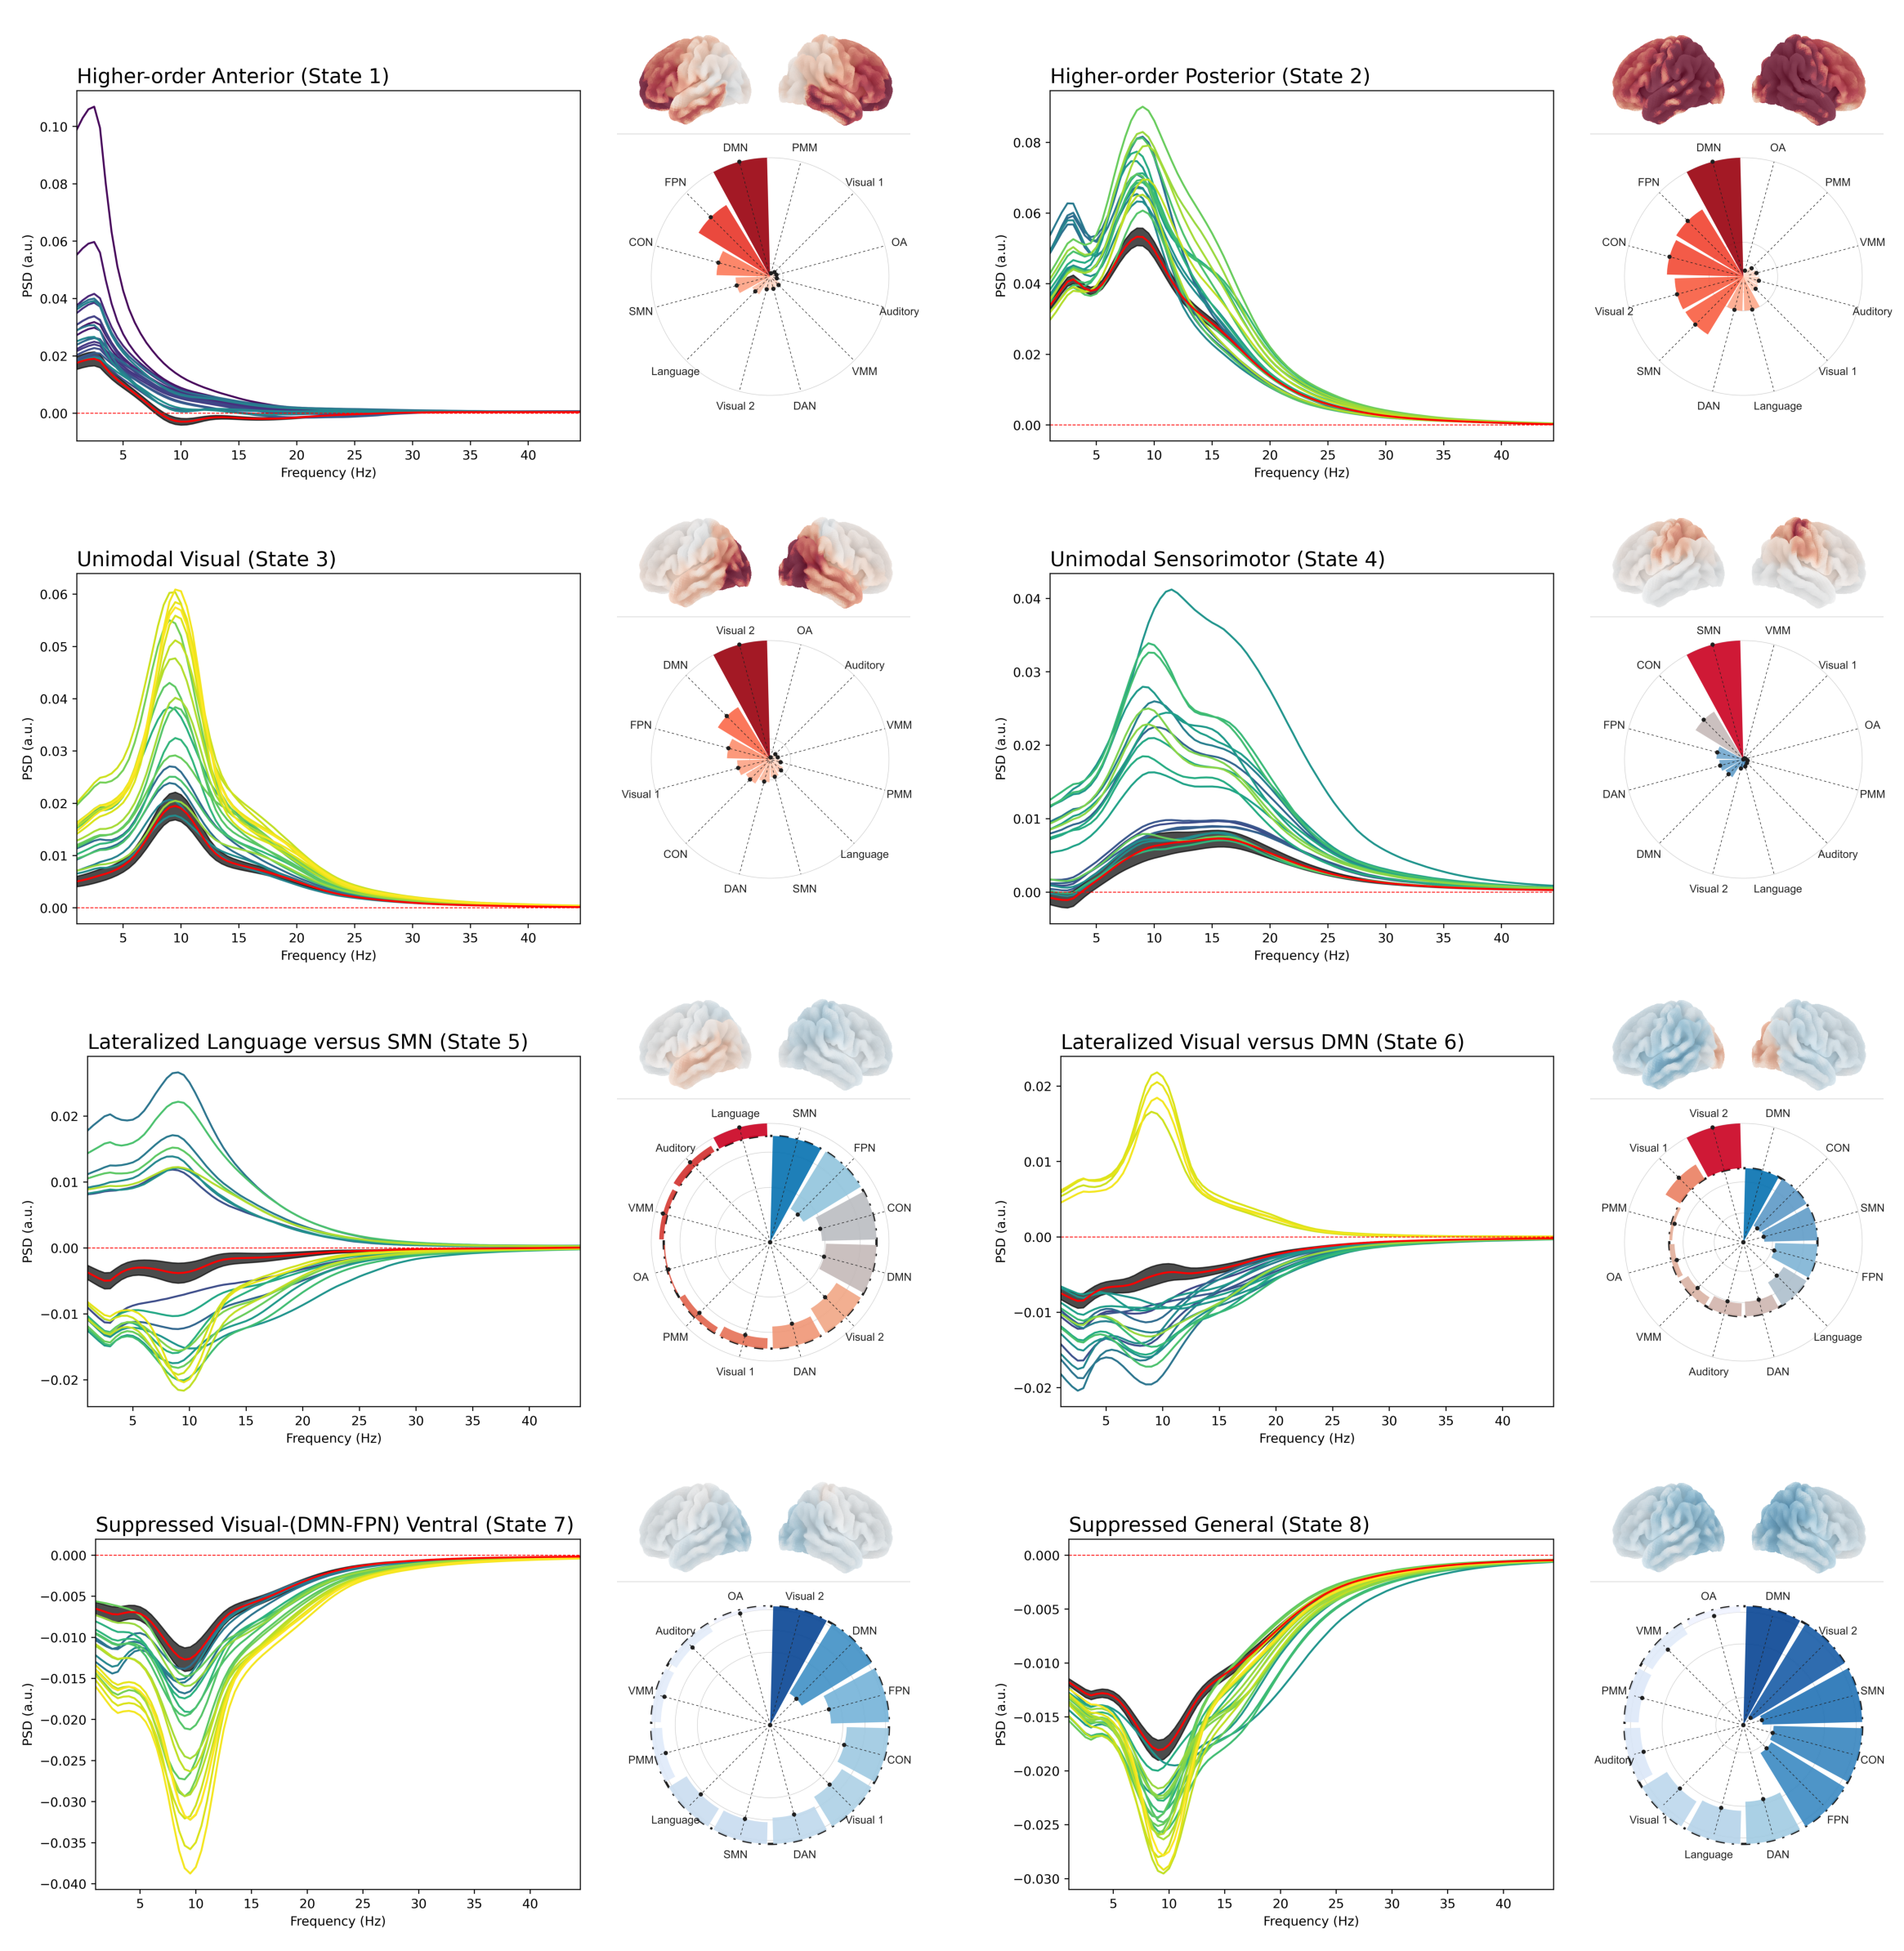

In [34]:
from osl_dynamics.utils.plotting import plot_markers
from osl_dynamics.utils.plotting import plot_psd_topo
from matplotlib.image import imread

nparcels = 20

fig, axs = plt.subplots(4, 2, figsize=(30, 30))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

for state, ax_subplot in enumerate(axs.flat):

    #################################################################################
    # Main plot
    #################################################################################
    fig, ax = plot_psd_topo(
        f,
        gpsd_dyn_reordered[state,...],
        only_show=idx_parcels_reordered[state,-nparcels:]
        )
    ax.axhline(y = 0, color = 'r', linestyle = '--', linewidth = 2/3)
    ax.set_title(f"{brain_states_dict[state+1]} (State {state+1})", loc='left', fontsize = 16)

    # Plot the state mean ########################################################
    saliency_mean = np.mean(gpsd_dyn_reordered[state,:,:],axis=-2) # Mean across channels
    saliency_se = np.std(gpsd_dyn_reordered[state,:,:],axis=-2) / np.sqrt(52) # Standard error across channels
    ax.fill_between(f, saliency_mean-saliency_se, saliency_mean+saliency_se, color='black', alpha=0.7)
    ax.plot(f, saliency_mean, color='r') # type: ignore

    # State-relevant frequency band ##############################################
    # inside_ax = ax.inset_axes([0.74, 0.02, 0.25, 0.25]) # type: ignore
    # plotting.plot_line(
    #     [f],  # we need to repeat f times because we fitted f components
    #     [weights_freqranges[state,:]],
    #     ax=inside_ax,
    #     plot_kwargs={"color": "black",
    #                  "linestyle": "dashdot"}
    # )  # type: ignore
    # plt.suptitle("Relevant\n frequency\n band", fontsize = 9, x = 0.91, y = 0.28)
    # inside_ax.set_xticks(np.arange(0,60,15))
    # inside_ax.tick_params(left = False, labelleft = False,
    #                       bottom = False, labelbottom = False,
    #                       labelsize = 7, length=3)
    # inside_ax.fill_between(f,weights_freqranges[state,:], alpha = .8, color = "grey")


    # Save individual state before embedding in subplots #############################
    plt.tight_layout()
    psd_img_path = f"{output_dir}/2_Brain_state_analysis/figs/subfig_state_{state+1}.png"
    plt.savefig(psd_img_path, dpi = 400)
    plt.close()

    # #################################################################################
    # # Subplot Embedding
    # #################################################################################
    png_path = f"{output_dir}/2_Brain_state_analysis/figs/subfig_state_{state+1}.png"
    main_img = imread(png_path, format="png")
    ax_subplot.imshow(main_img)
    ax_subplot.axis('off')

    # RSN composition #########################################################
    img = imread(f"{output_dir}/2_Brain_state_analysis/R/_Glasser52_to_CABNP/output/State_{state+1}_RSN_composition.png")

    center = np.array(img.shape[:2]) / 2
    radius = min(img.shape[:2]) / 2
    y, x = np.ogrid[:img.shape[0], :img.shape[1]]
    circle = ((x - center[1]) ** 2 + (y - center[0]) ** 2 > radius ** 2)
    mask = np.ones_like(img[..., 0])
    mask[circle] = 0 # Setting anything outside the mask to transparent
    cropped_image = np.dstack((img, mask))
    
    inside_ax_subplot = ax_subplot.inset_axes([0.95, 0.14, 0.7, 0.7])
    inside_ax_subplot.imshow(cropped_image)
    inside_ax_subplot.axis('off')

    # # Spatial power maps #######################################################
    png_path = f"{output_dir}/2_Brain_state_analysis/figs/gpow_dyn_{state}.png"
    img_power_map = imread(png_path, format="png")
    # Create a rectangular mask to crop the bottom part
    mask = np.ones_like(img_power_map)
    mask[-150:, :] = 0 
    cropped_image = img_power_map * mask

    inside_ax_subplot2 = ax_subplot.inset_axes([1.04, 0.65, 0.5, 0.5])
    inside_ax_subplot2.imshow(cropped_image)
    inside_ax_subplot2.axis('off')
    
plt.savefig(f"{output_dir}/2_Brain_state_analysis/figs/Figure_1.png")
plt.savefig(f"{output_dir}/2_Brain_state_analysis/figs/Figure_1.svg")

DATAPREP for PLS SPECTRAL

In [12]:
nparcels=20
psd_pls = np.zeros([621,8,nparcels,88])

for sub in range(621):
    for state in range(8):
        parcels = idx_parcels[state,-nparcels:]
        psd_pls[sub,state,...] = psd[sub,state,parcels] # (subjects,states,channels,freqs)
print(psd_pls.shape)
np.save(f"{output_dir}/3_Neurocognitive_analysis/psd_pls.npy", psd_pls)

(621, 8, 20, 88)


DATAPREP for PLS TRANSITION

In [4]:
import pickle
from osl_dynamics.inference import modes

BASE_DIR = "E:/Research_Projects/MEG_CamCAN"
alpha = pickle.load(open(f"{spectra_dir}/alp.pkl", "rb"))
stc = modes.argmax_time_courses(alpha)

In [ ]:
def compute_transition_matrices(participants_data):
    """
    Compute transition probability matrices for a list of participants.

    Args:
    participants_data (list of np.ndarray): List containing numpy arrays for each participant. 
                                            Each array has dimensions (number_of_points, 8).

    Returns:
    list of np.ndarray: List of transition probability matrices for each participant.
    """
    transition_matrices = []
    
    for data in participants_data:
        data_state_reordered = data[:,state_reordered]
        num_points, num_states = data_state_reordered.shape
        transition_counts = np.zeros((num_states, num_states))
        
        for t in range(num_points - 1):
            current_state = data_state_reordered[t]
            next_state = data_state_reordered[t + 1]
            
            for i in range(num_states):
                if current_state[i] == 1:
                    for j in range(num_states):
                        if next_state[j] == 1 and i != j:
                            transition_counts[i, j] += 1
        
        transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)
        transition_probs = np.nan_to_num(transition_probs)  # Handle division by zero
        
        transition_matrices.append(transition_probs)
    
    return transition_matrices


transition_matrices = compute_transition_matrices(stc)
np.save(f"{spectra_dir}/trans_prob_subj.npy", transition_matrices)

DATAPREP for PLS TEMPORAL

In [ ]:
# Plot the state time course for the 1st subject (1 seconds because sampled at 250Hz)
plotting.plot_alpha(stc[467][...,state_reordered], n_samples=250*1)

In [ ]:
from scipy import stats

# FO
fo_reordered = np.load(f"{spectra_dir}/fo.npy")[...,state_reordered]
np.save(f"{spectra_dir}/fo_reordered.npy",fo_reordered)
# Plot the distribution of fractional occupancy (FO) across subjects
plotting.plot_violin(fo_reordered.T, x_label="State", y_label="FO")

# LT
lt_reordered = np.load(f"{spectra_dir}/lt.npy")[...,state_reordered]
np.save(f"{spectra_dir}/lt_reordered.npy",lt_reordered)
lt_reordered *= 1000 # Convert to ms
# Plot the distribution of mean lifetimes across subjects
plotting.plot_violin(lt_reordered.T, x_label="State", y_label="Mean Lifetime (ms)")
np.std(lt_reordered,0)
# np.median(np.std(lt_reordered,0))

for state in range(8):
    res = stats.levene(lt_reordered[:,state], np.mean(lt_reordered,axis=1))
    print(f"State {state+1}: {res}")
    
# INTV
intv_reordered = np.load(f"{spectra_dir}/intv.npy")[...,state_reordered]
np.save(f"{spectra_dir}/intv_reordered.npy",intv_reordered)
# Plot the distribution of mean interval across subjects
plotting.plot_violin(intv_reordered.T, x_label="State", y_label="Mean Interval (s)")
np.std(intv_reordered,0)
np.median(np.std(intv_reordered,0))


for state in range(8):
    res = stats.levene(intv_reordered[:,state], np.mean(intv_reordered,axis=1))
    print(f"State {state+1}: {res}")
    
# SR
sr_reordered = np.load(f"{spectra_dir}/sr.npy")[...,state_reordered]
np.save(f"{spectra_dir}/sr_reordered.npy",sr_reordered)
# Plot the distribution of switching rates across subjects
plotting.plot_violin(sr_reordered.T, x_label="State", y_label="Switching rate (Hz)")
np.std(sr_reordered,0)
np.median(np.std(sr_reordered,0))

for state in range(8):
    res = stats.levene(sr_reordered[:,state], np.mean(sr_reordered,axis=1))
    print(f"State {state+1}: {res}")